# Imports

In [2]:
from rdkit import Chem
from rdkit.Chem import Draw, rdChemReactions
import pandas as pd
import numpy as np
import re
import torch
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import GATConv, TransformerConv
from torch_geometric.loader import DataLoader
from sklearn.preprocessing import OneHotEncoder
import torch.nn as nn

# Data Parsing

### Load dataset

In [4]:
df = pd.read_csv('./data/dataSetB.csv')
df = df[[col for col in df if "NameRxn" in col]]

In [5]:
# df_train = pd.read_csv('./data/canonicalized_csv/train.csv')
# df_valid = pd.read_csv('./data/canonicalized_csv/train.csv')
# df_test = pd.read_csv('./data/canonicalized_csv/test.csv')

### Smiles to Reactions

In [6]:

# def smiles_to_rxns(df):
#     rxn_list = []
#     for idx, row in df.iterrows():
#         reactants, products = row['rxn_smiles'].split('>>')

#         reactants = reactants.split('.')
#         products = products.split('.')

#         reactant_mols = [Chem.MolFromSmiles(reactant) for reactant in reactants]
#         product_mols = [Chem.MolFromSmiles(product) for product in products]

#         rxn_list.append((reactant_mols,product_mols))
#     return rxn_list

In [7]:
# train_rxns = smiles_to_rxns(df_train)
# validation_rxns = smiles_to_rxns(df_valid)
# test_rxns = smiles_to_rxns(df_test)

In [8]:
def parse_rxn_smile(rxn_smile,reactant_set):
    before_rxn_smile, products_smile = rxn_smile.split('>>')

    reactant_indices = [int(x) for x in re.findall(r'\d+', reactant_set)]

    potential_reactants = before_rxn_smile.split('.')
    reactants = [potential_reactants[idx] for idx in reactant_indices]

    products = products_smile.split('.')

    return reactants,products

In [9]:
rxn_list = []
for idx, row in df.iterrows():
    rxn_smile = row['rxnSmiles_Mapping_NameRxn']
    reactant_set = row['reactantSet_NameRxn']

    reactants, products = parse_rxn_smile(rxn_smile,reactant_set)

    reactant_mols = [Chem.MolFromSmiles(reactant) for reactant in reactants]
    product_mols = [Chem.MolFromSmiles(product) for product in products]

    rxn_list.append((reactant_mols,product_mols))


### Reaction cleanup

In [10]:
# problems_w = 0
# problems_e = 0
# i = 0
cleaned_rxn_list = []
for idx, rxn in enumerate(rxn_list):
    rd_rxn = rdChemReactions.ChemicalReaction()
    for rctnt in rxn[0]:
        rd_rxn.AddReactantTemplate(rctnt)
    for prdct in rxn[1]:
        rd_rxn.AddProductTemplate(prdct)

    warnings, errors = rd_rxn.Validate()
    if(not warnings and not errors and not len(rxn[1])>1):
        cleaned_rxn_list.append(rd_rxn)
    # problems_w+=warnings
    # problems_e+=errors
# print(problems_w,problems_e)

[09:51:18] product atom-mapping number 1 found multiple times.
[09:51:18] product atom-mapping number 2 found multiple times.
[09:51:18] product atom-mapping number 3 found multiple times.
[09:51:18] product atom-mapping number 4 found multiple times.
[09:51:18] product atom-mapping number 5 found multiple times.
[09:51:18] product atom-mapping number 6 found multiple times.
[09:51:18] product atom-mapping number 7 found multiple times.
[09:51:18] product atom-mapping number 25 found multiple times.
[09:51:18] product atom-mapping number 26 found multiple times.
[09:51:18] product atom-mapping number 27 found multiple times.
[09:51:18] product atom-mapping number 28 found multiple times.
[09:51:18] product atom-mapping number 29 found multiple times.
[09:51:18] product atom-mapping number 30 found multiple times.
[09:51:18] product atom-mapping number 31 found multiple times.
[09:51:18] product atom-mapping number 32 found multiple times.
[09:51:18] product atom-mapping number 33 found

# Feature extraction

In [11]:
symbol_list = [
        'C', 'N', 'O', 'S', 'F', 'H', 'Si', 'P', 'Cl', 'Br', 'Li', 'Na', 'K',
        'Mg', 'B', 'Sn', 'I', 'Se', 'unk'
    ]

hyb_list = [
    Chem.rdchem.HybridizationType.SP, 
    Chem.rdchem.HybridizationType.SP2,
    Chem.rdchem.HybridizationType.SP3,
    Chem.rdchem.HybridizationType.SP3D,
    Chem.rdchem.HybridizationType.SP3D2
    ]

bt_list = [
    Chem.rdchem.BondType.SINGLE,
    Chem.rdchem.BondType.DOUBLE,
    Chem.rdchem.BondType.TRIPLE,
    Chem.rdchem.BondType.AROMATIC
]

sym_encoder = OneHotEncoder(dtype=np.float32, sparse_output=False)
hyb_encoder = OneHotEncoder(dtype=np.float32, sparse_output=False)
bt_encoder = OneHotEncoder(dtype=np.float32, sparse_output=False)

sym_encoder.fit(np.array(symbol_list).reshape(-1,1))
hyb_encoder.fit(np.array(hyb_list).reshape(-1,1))
bt_encoder.fit(np.array(bt_list).reshape(-1,1))

def one_hot_encode(symbol,encoder):
    try: 
        return torch.tensor(encoder.transform(np.array([[symbol]])).reshape(-1), dtype=torch.float)
    except:
        return torch.tensor(encoder.transform(np.array([['unk']])).reshape(-1), dtype=torch.float)


In [12]:
def get_atom_features(atom):
    sym_one_hot = one_hot_encode(atom.GetSymbol(),sym_encoder)
    formal_charge = torch.tensor([atom.GetFormalCharge()], dtype=torch.float)
    degree = torch.tensor([atom.GetDegree()], dtype=torch.float)
    total_hydrogens = torch.tensor([atom.GetTotalNumHs()], dtype=torch.float)
    valence = torch.tensor([atom.GetTotalValence()], dtype=torch.float)
    is_aromatic = torch.tensor([atom.GetIsAromatic()], dtype=torch.float)
    is_in_ring = torch.tensor([atom.IsInRing()], dtype=torch.float)
    hyb_one_hot = one_hot_encode(atom.GetHybridization(),hyb_encoder)
    
    features = torch.cat([sym_one_hot, formal_charge, degree, total_hydrogens, valence, is_aromatic, is_in_ring, hyb_one_hot])

    return features


def get_bond_features(bond):
    # bond type, conjugation, ring membership,  stereo config
    bt_one_hot = one_hot_encode(bond.GetBondType(),bt_encoder)
    is_conjugated = torch.tensor([bond.GetIsConjugated()],dtype=torch.float)
    is_in_ring = torch.tensor([bond.IsInRing()],dtype=torch.float)

    
    features = torch.cat([bt_one_hot,is_conjugated,is_in_ring])

    return(features)


# Input Preparation

In [13]:
def get_broken_bonds(reactants,product):
    reactant_bonds = set()
    product_bonds = set()
    for rc in reactants:
        for bond in rc.GetBonds():
            atom1_map = bond.GetBeginAtom().GetAtomMapNum()
            atom2_map = bond.GetEndAtom().GetAtomMapNum()

            if atom1_map and atom2_map:
                reactant_bonds.add(tuple(sorted((atom1_map, atom2_map))))

    for bond in product.GetBonds():
        atom1_map = bond.GetBeginAtom().GetAtomMapNum()
        atom2_map = bond.GetEndAtom().GetAtomMapNum()
        
        if atom1_map and atom2_map:
            product_bonds.add(tuple(sorted((atom1_map, atom2_map))))

    broken_bonds = reactant_bonds - product_bonds
    formed_bonds = product_bonds - reactant_bonds

    return formed_bonds

# Model Definition

In [ ]:
from torch_geometric.nn import global_mean_pool
class GraphTransformer(nn.Module):
    def __init__(self, in_channels, edge_dim, hidden_channels, out_channels, heads=8):
        super().__init__()
        out_channels_per_head = hidden_channels // heads
        
        self.conv1 = TransformerConv(in_channels, out_channels_per_head, heads=heads, edge_dim=edge_dim)
        self.conv2 = TransformerConv(hidden_channels, out_channels, heads=1, concat=False, edge_dim=edge_dim)

    def forward(self, x, edge_index, edge_attr):
        h = self.conv1(x, edge_index, edge_attr=edge_attr)
        h = F.leaky_relu(h)
        h = F.dropout(h, p=0.6, training=self.training)
        h = self.conv2(h, edge_index, edge_attr=edge_attr)
        return h

class LinkPredictor(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels=1):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(in_channels * 2, hidden_channels),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(hidden_channels, out_channels)
        )

    def forward(self, h, edge_index):
        source_embeds = h[edge_index[0]]
        target_embeds = h[edge_index[1]]
        concat_embeds = torch.cat([source_embeds, target_embeds], dim=1)
        return self.mlp(concat_embeds)

class GNN_LinkPredictor(nn.Module):
    def __init__(self, node_in, edge_in, gnn_hidden, mlp_hidden):
        super().__init__()
        self.gnn = GraphTransformer(
            in_channels=node_in,
            edge_dim=edge_in,
            hidden_channels=gnn_hidden,
            out_channels=gnn_hidden
        )
        self.predictor = LinkPredictor(gnn_hidden*2, mlp_hidden)

    def forward(self, x, edge_index, edge_attr, edge_label_index,batch):
        node_embeddings = self.gnn(x, edge_index, edge_attr)
        graph_embedding = global_mean_pool(node_embeddings, batch)
        graph_embedding_expanded = graph_embedding[batch]
        node_embeddings_with_context = torch.cat(
            [node_embeddings, graph_embedding_expanded], dim=1
        )
        return self.predictor(node_embeddings_with_context, edge_label_index)

In [ ]:
def rxn_to_graph(rxn):
    reactants = rxn.GetReactants()
    product = rxn.GetProducts()[0]

    center_bonds = get_broken_bonds(reactants, product)
    center_bonds_set = {tuple(sorted((u - 1, v - 1))) for u, v in center_bonds}

    atom_features_list = [get_atom_features(atom) for atom in product.GetAtoms()]
    
    x = torch.stack(atom_features_list, dim=0)

    # Get edge and edge_attr
    source_nodes, target_nodes = [], []
    bond_features_list = []
    edge_labels = []
    for bond in product.GetBonds():
        start, end = bond.GetBeginAtomIdx(), bond.GetEndAtomIdx()
        bond_feat = get_bond_features(bond)
        
        # Add edges in both directions
        source_nodes.extend([start, end])
        target_nodes.extend([end, start])
        
        # Add bond features for both directions
        bond_features_list.extend([bond_feat, bond_feat])

        canonical_bond = tuple(sorted((start, end)))
        if canonical_bond in center_bonds_set:
            label = 1.0
        else:
            label = 0.0

        edge_labels.extend([label,label])

    edge_index = torch.tensor([source_nodes, target_nodes], dtype=torch.long)
    edge_attr = torch.stack(bond_features_list, dim=0)

    y = torch.tensor(edge_labels, dtype=torch.float)
        
    return Data(x=x, edge_index=edge_index, edge_attr=edge_attr, y=y)
    
    

In [22]:
from tqdm import tqdm
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using {device}.")

dataset = [rxn_to_graph(rxn) for rxn in tqdm(cleaned_rxn_list)]
# dataset = torch.load('rxn_graphs.pt')

train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_dataset = dataset[:train_size]
val_dataset = dataset[train_size : train_size + val_size]
test_dataset = dataset[train_size + val_size :]

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False) # No need to shuffle for eval
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


torch.save(dataset, 'rxn_graphs.pt')

Using cuda.


100%|██████████| 48232/48232 [26:13<00:00, 30.65it/s]


In [32]:
from sklearn.metrics import roc_auc_score
from torch_geometric.utils import negative_sampling

# Model instantiation
node_feature_dim = dataset[0].num_node_features
edge_feature_dim = dataset[0].num_edge_features


model = GNN_LinkPredictor(node_feature_dim, edge_feature_dim, gnn_hidden=64, mlp_hidden=32).to(device)
# model = torch.load('model2.pt', weights_only=False)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.BCEWithLogitsLoss()


def train(loader):
    model.train()
    for batch in tqdm(loader, desc="Training"):
        batch = batch.to(device)

        optimizer.zero_grad()

        out = model(
            batch.x, 
            batch.edge_index,
            batch.edge_attr, 
            batch.edge_index,
            batch.batch
        )
        
        loss = criterion(out.view(-1), batch.y)
        # ------------------------

        loss.backward()
        optimizer.step()

@torch.no_grad()
def test(loader):
    model.eval()
    all_preds, all_labels = [], []

    for batch in loader:
        batch = batch.to(device)
        
        # Get predictions for ALL bonds in the batch
        preds = model(
            batch.x, 
            batch.edge_index, 
            batch.edge_attr, 
            batch.edge_index,
            batch.batch
        )
        
        # Use the pre-computed labels from batch.y
        labels = batch.y
        
        all_preds.append(preds.sigmoid().cpu())
        all_labels.append(labels.cpu())

    if not all_labels:
        return 0.0, 0.0  # Return 0 for both AUC and F1

    all_labels_tensor = torch.cat(all_labels)
    all_preds_tensor = torch.cat(all_preds)
    
    # Calculate Metrics
    auc = roc_auc_score(all_labels_tensor, all_preds_tensor)
    # f1 = f1_score(all_labels_tensor, (all_preds_tensor > threshold).int())
    
    return auc, all_labels_tensor, all_preds_tensor




In [33]:
for epoch in range(1, 21):
   train(train_loader)
   val_auc,_, _ = test(val_loader)
   print(f'Epoch: {epoch:02d}, Val AUC: {val_auc:.4f}')

torch.save(model,'model2.pt')

Training: 100%|██████████| 1206/1206 [00:12<00:00, 95.59it/s]


Epoch: 01, Val AUC: 0.8895


Training: 100%|██████████| 1206/1206 [00:12<00:00, 93.58it/s]


Epoch: 02, Val AUC: 0.9141


Training: 100%|██████████| 1206/1206 [00:12<00:00, 95.27it/s] 


Epoch: 03, Val AUC: 0.9245


Training: 100%|██████████| 1206/1206 [00:13<00:00, 92.64it/s]


Epoch: 04, Val AUC: 0.9304


Training: 100%|██████████| 1206/1206 [00:12<00:00, 94.97it/s]


Epoch: 05, Val AUC: 0.9375


Training: 100%|██████████| 1206/1206 [00:12<00:00, 93.55it/s]


Epoch: 06, Val AUC: 0.9380


Training: 100%|██████████| 1206/1206 [00:12<00:00, 94.30it/s]


Epoch: 07, Val AUC: 0.9410


Training: 100%|██████████| 1206/1206 [00:12<00:00, 96.47it/s] 


Epoch: 08, Val AUC: 0.9435


Training: 100%|██████████| 1206/1206 [00:12<00:00, 93.65it/s] 


Epoch: 09, Val AUC: 0.9472


Training: 100%|██████████| 1206/1206 [00:11<00:00, 102.82it/s]


Epoch: 10, Val AUC: 0.9473


Training: 100%|██████████| 1206/1206 [00:11<00:00, 105.31it/s]


Epoch: 11, Val AUC: 0.9477


Training: 100%|██████████| 1206/1206 [00:10<00:00, 113.10it/s]


Epoch: 12, Val AUC: 0.9504


Training: 100%|██████████| 1206/1206 [00:12<00:00, 96.73it/s] 


Epoch: 13, Val AUC: 0.9516


Training: 100%|██████████| 1206/1206 [00:12<00:00, 95.02it/s]


Epoch: 14, Val AUC: 0.9529


Training: 100%|██████████| 1206/1206 [00:11<00:00, 102.81it/s]


Epoch: 15, Val AUC: 0.9527


Training: 100%|██████████| 1206/1206 [00:10<00:00, 109.98it/s]


Epoch: 16, Val AUC: 0.9535


Training: 100%|██████████| 1206/1206 [00:10<00:00, 112.70it/s]


Epoch: 17, Val AUC: 0.9539


Training: 100%|██████████| 1206/1206 [00:10<00:00, 116.11it/s]


Epoch: 18, Val AUC: 0.9560


Training: 100%|██████████| 1206/1206 [00:09<00:00, 130.47it/s]


Epoch: 19, Val AUC: 0.9550


Training: 100%|██████████| 1206/1206 [00:09<00:00, 124.44it/s]


Epoch: 20, Val AUC: 0.9572


In [ ]:
print(len(test_dataset))

for 

4824


In [3]:
mdl = torch.load('model2.pt', weights_only=False)
print(mdl)

AttributeError: Can't get attribute 'GNN_LinkPredictor' on <module '__main__'>

Evaluating final model and generating ROC curve...
              precision    recall  f1-score   support

         0.0       0.99      1.00      1.00    267882
         1.0       0.77      0.06      0.12      1480

    accuracy                           0.99    269362
   macro avg       0.88      0.53      0.56    269362
weighted avg       0.99      0.99      0.99    269362



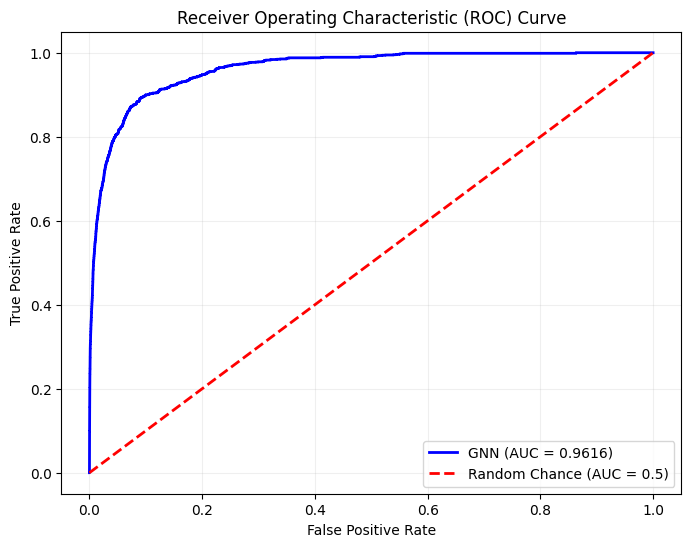

In [34]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, classification_report

# --- After your training loop is finished ---
print("Evaluating final model and generating ROC curve...")

# 1. Get the final AUC, labels, and predictions from your test set
final_auc, true_labels, predictions = test(test_loader) # or use val_loader

binary_preds = (predictions > 0.5).int()

print(classification_report(true_labels,binary_preds))

if true_labels is not None:
    # 2. Calculate the points for the ROC curve
    fpr, tpr, _ = roc_curve(true_labels, predictions)

    # 3. Plot the curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'GNN (AUC = {final_auc:.4f})')
    
    # Plot the random chance line
    plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--', label='Random Chance (AUC = 0.5)')
    
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.grid(alpha=0.2)
    plt.show()